# CSCI 3352 Biological Networks, Spring 2020, Prof. Clauset
Submit here: https://moodle.cs.colorado.edu/course/view.php?id=1273

# Problem Set 9 : Metabolic Networks

***

**Name**: Julia Sanford

**Worked with**: Denver Chernin

***

This *OPTIONAL* assignment is due on Moodle by **11:55pm on Friday, April 17th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 0 points total, and 100 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Moodle.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
def drawGz_circular(G,z):
    # MODIFY THIS FUNCTION AS NEEDED
    # This function draws G as a CIRCULAR LAYOUT with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : a circular layout plot (ignores edge weights)
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors,pos = nx.circular_layout(G)) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes 
    plt.show() 

    return

***
## Problem 1 : Metabolic reaction networks and fluxes (*60 pts total extra credit*)

### Problem 1-A (*10 pts extra credit*) : Constructing a metabolite-reaction network

Consider the following set of abstract chemical reactions, where $R_i$ is the $i$th reaction, the arrow $\to$ indicates a one-way reaction while $\leftrightarrow$ indicates a reaction that could go in either direction.
* $R_1$ : $A \to X_1$
* $R_2$ : $X_1 \to X_2$
* $R_3$ : $X_2 \to X_3$
* $R_4$ : $X_2 \leftrightarrow X_4$
* $R_5$ : $X_3 \to X_5$
* $R_6$ : $X_4 \to X_5$
* $R_7$ : $X_4 \to W$
* $R_8$ : $X_3 + 2X_4 + X_5 \to B$

where $A$ is the nutrient input, $B$ is the biomass output and $W$ is waste output.

* Construct and visualize a _directed bipartite_ representation of these reactions as a metabolite-reaction graph (see Lecture sketch 10).
* Construct and display a _stoichiometric matrix_ representation of these same reactions (the rows should correspond to metabolites, listed in _alphanumeric_ order, and the columns should be reactions in _alphanumeric_ order).

Hint: `networkx` doesn't have a native [bipartite](https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html) data structure, so we'll have to fake it using a `DiGraph` and a partition `z` of the nodes into the two sets.

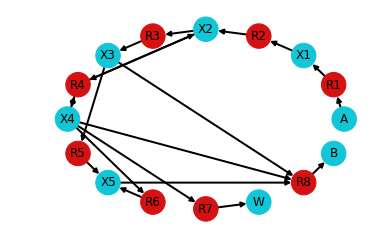

In [3]:
### YOUR CODE HERE
G = nx.DiGraph([('A','R1'),('R1','X1'),('X1','R2'),('R2','X2'),('X2','R3'),('R3','X3'),('X2','R4'),('R4','X4'),('X4','R4'),('R4','X2'),('X3','R5'),('R5','X5'),('X4','R6'),('R6','X5'),('X4','R7'),('R7','W'),('X3','R8'),('X4','R8'),('X4','R8'),('X5','R8'),('R8','B')])
z = {}
for n in G.nodes():
    if n[0] == 'R':
        z[n] = 0
    else:
        z[n] = 1
        
drawGz_circular(G,z)

\begin{bmatrix}
   & R1 & R2 & R3 & R4 & R5 & R6 & R7 & R8 \\
A  & -1 & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
X1 & 1  & -1 & 0  & 0  & 0  & 0  & 0  & 0  \\
X2 & 0  & 1  & -1 & -1 & 0  & 0  & 0  & 0  \\
X3 & 0  & 0  & 1  & 0  & -1 & 0  & 0  & -1 \\
X4 & 0  & 0  & 0  & 1  & 0  & -1 & -1 & -2 \\
X5 & 0  & 0  & 0  & 0  & 1  & 1  & 0  & -1 \\
W  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & 0  \\
B  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  \\
\end{bmatrix}

### Problem 1-B (*15 pts extra credit*) : One-mode representations

Recall from Lecture 11 that there are several different ways to represent metabolic networks. The directed bipartite version from `Problem 1-A` is the kind most amenable to flux balance analysis. But, for structural analyses, the one-mode representations of a `substrate-product graph` and a `reaction network` are more conventional.

* Write a function `convertTo_SPGraph()` that takes as input (1) a directed bipartite graph `G` and (2) the partition dictionary `z`, and returns the corresponding substrate-product graph.
* Write a function `convertTo_RxnGraph()` that takes as input (1) a directed bipartite graph `G` and (2) the partition dictionary `z`, and returns the corresponding reaction network.
* Apply both of your functions to the graph from `Problem 1-A` and display the results using `drawGz_circular()`. Be sure to label which output graph is which.

Hint: to make the reaction network, it may be easier to first convert the directed bipartite network into an undirected bipartite network.

In [4]:
### YOUR FUNCTIONS HERE
def convertTo_SPGraph(G, z):
    spg = nx.Graph()
    for n in G.nodes():
        if (z[n] == 1):
            spg.add_node(n)
            
    for e1 in G.edges():
        if (z[e1[1]] == 0):
            for e2 in G.edges():
                if (e1[1] == e2[0]):
                    if (z[e2[0]] == 0):
                        spg.add_edge(e1[0], e2[1])
                    
    return spg
    
def convertTo_RxnGraph(G, z):
    G = G.to_undirected()
    rxn = nx.Graph()
    for n in G.nodes():
        if (z[n] == 0):
            rxn.add_node(n)
            
    for n1 in rxn.nodes():
        for n2 in rxn.nodes():
            if (n1 != n2):
                for neigh1 in G.neighbors(n1):
                    for neigh2 in G.neighbors(n2):
                        if (neigh1 == neigh2):
                            rxn.add_edge(n1,n2)
    
    return rxn
            

Substrate-Product Graph:


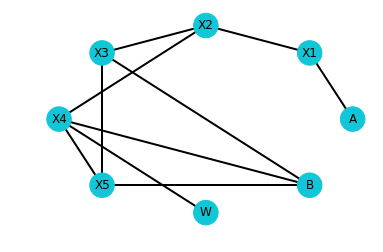

Reaction Graph:


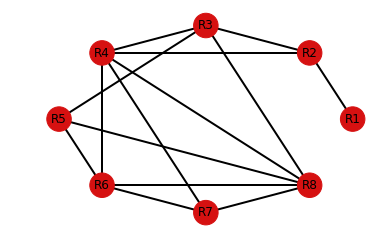

In [5]:
### YOUR APPLICATION OF THEM HERE
G_sp = convertTo_SPGraph(G,z)
print("Substrate-Product Graph:")
drawGz_circular(G_sp,z)

G_rxn = convertTo_RxnGraph(G,z)
print("Reaction Graph:")
drawGz_circular(G_rxn,z)

### Problem 1-C (*35 pts extra credit*) : Just go with the flux

The following tables describe two experiments, in the form of minimum $v_\min$ and maximum $v_\max$ fluxes through each reaction, and the corresponding optimal flux solution $v_{\rm sol}$ computed via flux balance analysis on our metabolic pathway.

For each experiment, 
* verify that the flux through the biomass reaction $R_8$ is correct (explain this in words, tracing how the "units" of nutrient $A$ get converted into units of intermediate metabolites that add up to the given flux to biomass $B$), and
* verify that the FBA solution $v_{\rm sol}$ produces a _balanced_ set of internal fluxes, i.e., let $\textbf{S}\textbf{v}=\textbf{m}$, and then verify that $m_i=0$ for the $i$th metabolite, unless $i$ is an input or output of the pathway.
* Make circular plot visualizations of the two flux vectors $v_{\rm sol}$ on the edges of the reaction network.

Show your work.

1. Experiment: optimize biomass with zero waste

| reaction | $v_\min$  | $v_\max$  | $v_{\rm sol}$ |
|---|---|---|---|
| $R_1$  | 10 | 10  | 10  |
| $R_2$  | 0 | 10  | 10  |
| $R_3$  | 0 | 10  | 4.992  |
| $R_4$  | -10 | 10  | 5.008  |
| $R_5$  | 0 | 10  | 2.492  |
| $R_6$  | 0 | 10  | 0.008  |
| $R_7$  | 0 | 10  | 0  |
| $R_8$  | 0 | 10  | 2.5  |

2. Experiment: optimize biomass with some waste

| reaction | $v_\min$  | $v_\max$  | $v_{\rm sol}$ |
|---|---|---|---|
| $R_1$  | 10 | 10  | 10  |
| $R_2$  | 0 | 10  | 10  |
| $R_3$  | 0 | 10  | 3.877  |
| $R_4$  | -10 | 10  | 6.123  |
| $R_5$  | 0 | 10  | 1.877  |
| $R_6$  | 0 | 10  | 0.123  |
| $R_7$  | 2 | 10  | 2  |
| $R_8$  | 0 | 10  | 2  |

Hint: The flux balance requirement $\textbf{S}\textbf{v} =0$ is a matrix multiplication operation, which you can do via `numpy`. The result will be a column-vector of "metabolite" terms $m_i$, listed in the order of your metabolites in $G$.

Your $R_8$ explanation here

In [6]:
### YOUR CODE HERE

Your explanation here

***
## Problem 2 : The "universal metabolic network"  (*25 pts total extra credit*)

The paper Maslov et al. "[Toolbox model of evolution of prokaryotic metabolic networks and their regulation](https://www.pnas.org/content/106/24/9743)." _PNAS_ (2009) describes an effort in 2008 to construct a **universal biochemistry network** (or, an estimate of it). Their approach was to take the union of _all_ metabolic pathways contained in the KEGG database.

Pathways that occur in many species (common pathways, like "core" metabolism) will be well-represented in this network, while pathways that occur in only a few species (rare pathways, perhaps specific to only a small number of species) will only appear if their native species are in KEGG. In this problem, we will investigate the structure of this universal metabolic network, and investigate the degree to which it is _random_.

In [7]:
def extractRxnGraph_zdict(G):
    # MODIFY THIS FUNCTION AS NEEDED
    #
    # input  : G is a networkx graph
    # output : z is a dictionary of reaction (1) and metabolite (0) labels for G's nodes
    
    z = dict()
    for i in G.nodes():
        if i[0]=='R':
            z.update({i : 1})
        else:
            z.update({i : 0})

    return z

### Problem 2-A (*15 pts extra credit*) : Representations and structure

* Obtain the `SD1.xls` data file from the paper's webpage. Each row lists a reaction and two metabolites involved in that reaction.
* Transform the file into a metabolite-reaction network edge list, so that each row is a single pair of a reaction ID and _one_ of the metabolite IDs involved in it. (A few copy/paste operations.) Delete any excess columns. 
* Now load the metabolite-reaction edge list into `networkx` as a simple `Graph`.
* For each of the **three** representations (reaction-metabolite, substrate-product, and reaction), compute and report the following standard summary statistics:
  * number of nodes $n$
  * number of edges $m$
  * mean degree $\langle k \rangle$
  * clustering coefficient $C$
  * mean geodesic distance $\langle \ell \rangle$
  * the CCDF of the degree distribution
* In the markdown box below that, compare and contrast the statistics produced by the three representations. What differences do you observe, and why do those differences appear?

Hint 1: in the `SD1.xls` file, there are two tabs; you want the one with the larger number of reactions listed. This should produce a network with 11590 edges.

Hint 2: use the `plot_CCDF()` from, e.g., `PS5` and the `compute_MGD()` function from `PS3`.

In [8]:
### HELPER FUNCTIONS HERE

In [9]:
### YOUR CODE HERE

Your discussion here

### Problem 2-B (*15 pts extra credit*) : How random is metabolism?

* Use the Chung-Lu model to evaluate the degree to which the (1) clustering coefficient $C$ and (2) mean geodesic distance $\langle \ell \rangle$ for the _substrate-product_ network can be explained by _degree structure alone_.
* Discuss your findings in the markdown box below.

Hint: use the `plot_nullAndEmpirical()` function from `PS3` to plot each null distribution (based on, e.g., a few hundred random graphs) and its corresponding empirical value together to see how they compare.

In [10]:
### HELPER FUNCTION HERE

In [11]:
### YOUR CODE HERE

Your discussion here

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What paper did you choose?
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
P.S. Dodds, **Slightly generalized Generalized Contagion: Unifying simple models of biological and social spreading.** Preprint, arXiv:1708.09697 (2017).
<br/>


* *What was the research question?*<br/>
Your answer here
<br/>

* *What was the approach the authors took to answer that question?*<br/>
Your answer here
<br/>

* *What did they do well?*<br/>
Your answer here
<br/>

* *What could they have done better?*<br/>
Your answer here
<br/>

* *What extensions can you envision?*<br/>
Your answer here